In [1]:
import torch
from torch import nn,utils
from torchvision import datasets,transforms
from matplotlib import pyplot as plt
import os
%matplotlib inline

## Dataset loading

In [2]:
epoch = 20
batch_size = 100
lr = 0.0005

train = datasets.CIFAR10('./',train=True,transform=transforms.ToTensor(),target_transform=None,download=True)
test  = datasets.CIFAR10('./',train=False,transform=transforms.ToTensor(),target_transform=None,download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
loader = utils.data.DataLoader(train,batch_size=batch_size,shuffle=True)

## Encoder Model

In [148]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), # batch X 16 X 32 X 32
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,3,padding=1), # batch X 32 X 32 X 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,32,3,padding=1), # batch X 32 X 32 X 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,3,padding=1), # batch X 64 X 32 X 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,padding=1), # batch X 64 X 32 X 32
            nn.ReLU(),
            nn.BatchNorm2d(64), 
            nn.MaxPool2d(2,2)            # batch X 64 X 16 X 16
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1), # batch X 128 X 16 X 16
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,3,padding=1), # batch X 128 X 16 X 16
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3,padding=1), # batch X 256 X 16 X 16
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),              # batch X 256 X 8 X 8
            nn.Conv2d(256,256,3,padding=1), # batch X 256 X 8 X 8
            nn.ReLU(),
        )
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size,-1)
        return out
        
encoder = Encoder().cuda()        

## Decoder Model

In [154]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256,256,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256,128,3,2,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,128,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,64,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64,64,3,2,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64,32,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,32,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,3,3,1,1),
            nn.ReLU()
        )
    def forward(self,x):
        x = x.view(batch_size,256,8,8)
        out = self.layer1(x)
        out = self.layer2(out)
        return out
decoder = Decoder().cuda()

### Checking size

In [155]:
for image,label in loader:
    image = image.cuda()
    
    output = encoder(image)
    output = decoder(output)
    print(output.size())
    break

torch.Size([100, 3, 32, 32])


In [156]:
params = list(encoder.parameters()) + list(decoder.parameters())
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params,lr)

## Training

In [158]:
if not os.path.exists('./model'):
    os.mkdir('./model')
try:
    encoder, decoder = torch.load('./model/deno_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(epoch):
    for image,label in loader:
        image_n = torch.mul(image+0.25, 0.1 * torch.rand(batch_size,3,32,32))
        image = image.cuda()
        image_n = image_n.cuda()
        #label = label.float().cuda()
        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        loss = loss_fn(output,image)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(i + 1, epoch, loss.item()))
        
                
torch.save([encoder,decoder],'./model/deno_autoencoder.pkl')
print(loss)



--------model restored--------

epoch [1/20], loss:0.0067
epoch [2/20], loss:0.0056
epoch [3/20], loss:0.0053
epoch [4/20], loss:0.0051
epoch [5/20], loss:0.0053
epoch [6/20], loss:0.0055
epoch [7/20], loss:0.0058
epoch [8/20], loss:0.0050
epoch [9/20], loss:0.0053
epoch [10/20], loss:0.0051
epoch [11/20], loss:0.0068
epoch [12/20], loss:0.0052
epoch [13/20], loss:0.0056
epoch [14/20], loss:0.0054
epoch [15/20], loss:0.0052
epoch [16/20], loss:0.0053
epoch [17/20], loss:0.0060
epoch [18/20], loss:0.0055
epoch [19/20], loss:0.0053
epoch [20/20], loss:0.0053
tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>)


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "ty

In [244]:
image_n = torch.mul(image.cpu()+0.25,0.1* torch.rand(batch_size,3,32,32))
output = encoder(image_n.cuda())
output = decoder(output)

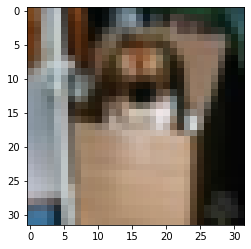

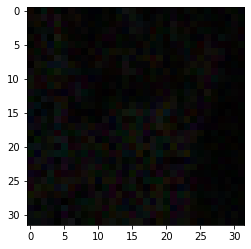

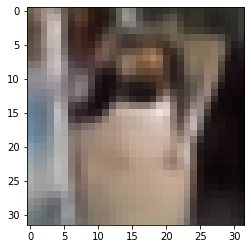

tensor(5)


In [245]:
img = image[40].cpu()
input_img = image_n[40].cpu()
output_img = output[40].detach().cpu()

plt.imshow(img.permute(1, 2, 0))
plt.show()

plt.imshow(input_img.permute(1, 2, 0))
plt.show()

plt.imshow(output_img.permute(1, 2, 0))
plt.show()

print(label[40])